# Importing Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Loading Data

In [2]:
# Set the file path for the dataset
file_path = r'C:\Users\Gowtham Ravuri\OneDrive\Documents\SEM-6\DL\DL Project\dataset\KDDTrain+.txt'


# Define column names (you can load them from a file if needed, or define them manually)
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files'
,'num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
,'dst_host_srv_rerror_rate','attack','level']

# Load dataset
data = pd.read_csv(file_path, header=None, names=columns)

# View dataset info
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())



Dataset Head:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   


# Preprocessing

### Encoding


In [3]:
cat_features = data.select_dtypes(include='object').columns
cat_features

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')

In [4]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
clm=['protocol_type', 'service', 'flag', 'attack']
for x in clm:
    data[x]=le.fit_transform(data[x])

### Test-Train Split

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(["attack"], axis=1)
y = data["attack"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=43) 

In [6]:
train_index = X_train.columns
train_index

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'level'],
      dtype='object')

## Feature Engineering

### Finding mutually related info of each column

In [7]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)

src_bytes                      0.930161
service                        0.760194
flag                           0.678892
diff_srv_rate                  0.655331
same_srv_rate                  0.621214
dst_host_diff_srv_rate         0.615123
count                          0.563204
dst_host_same_srv_rate         0.563145
dst_host_srv_count             0.541312
dst_bytes                      0.502813
dst_host_serror_rate           0.502254
serror_rate                    0.473620
dst_host_srv_serror_rate       0.444340
srv_serror_rate                0.425989
dst_host_same_src_port_rate    0.386423
level                          0.366018
logged_in                      0.357450
dst_host_srv_diff_host_rate    0.325161
dst_host_count                 0.297798
srv_count                      0.296347
protocol_type                  0.260833
dst_host_rerror_rate           0.204882
srv_diff_host_rate             0.183737
dst_host_srv_rerror_rate       0.156086
rerror_rate                    0.148684


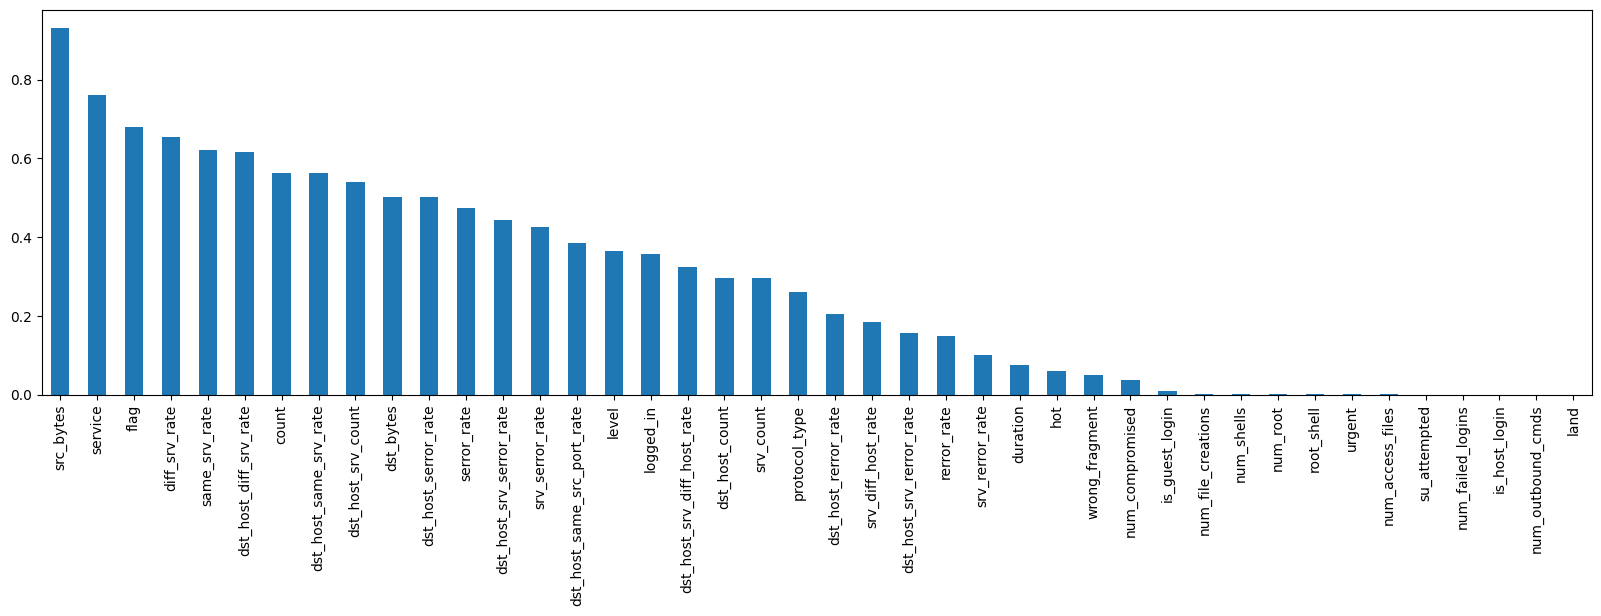

In [8]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 5));

### Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(X_train, y_train)
train_index[Select_features.get_support()]

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level'],
      dtype='object')

In [10]:
columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate']

#We will continue our model with top 15 features, because dataset is big enough

X_train=X_train[columns]
X_test=X_test[columns]

# Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # we use only transform in order to prevent data leakage

### Defining Attack and it's Visual Representation

In [12]:
attack_n = []
for i in data.attack :
  if i == 'normal':
    attack_n.append("normal")
  else:
    attack_n.append("attack")
data['attack'] = attack_n 
data['attack'].unique()

array(['attack'], dtype=object)

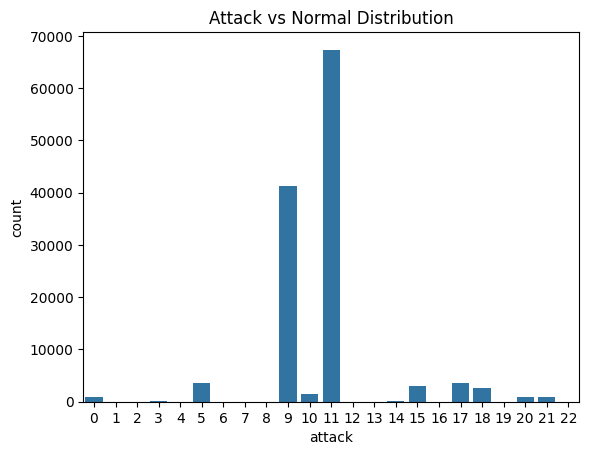

In [13]:
# Visualize attack distribution
sns.countplot(x=y)
plt.title("Attack vs Normal Distribution")
plt.show()


 ### Feature Correlation Heatmap

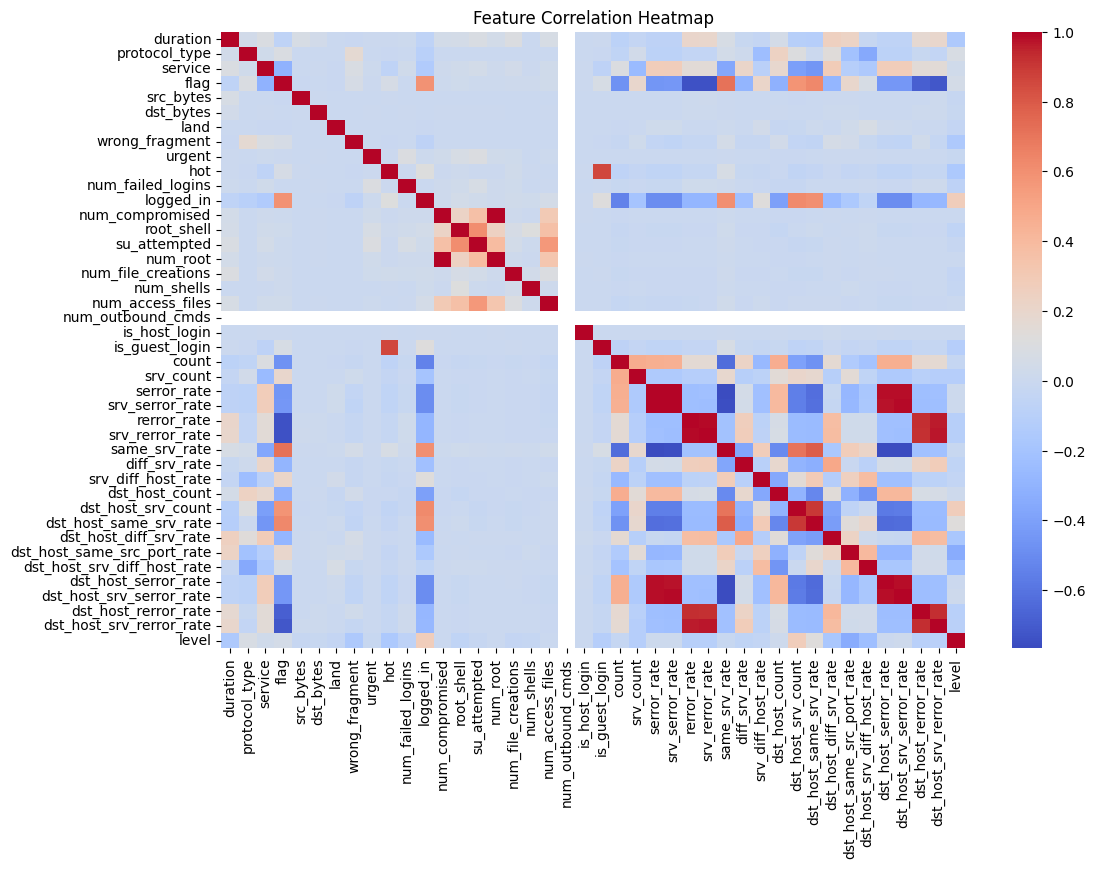

In [14]:
# Feature correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X).corr(), cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()


# Builing Logistic regression and XGBoost model

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Helper function to evaluate the models
def eval_metric(model, X_train, y_train, X_test, y_test):
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Evaluation on the test set
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
    print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

    try:
        # Check if the model supports `predict_proba()` and ROC AUC score
        if hasattr(model, "predict_proba"):
            # If it's binary classification
            if len(set(y_test)) == 2:
                print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
            else:  # For multi-class classification
                print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))
        else:
            print("ROC AUC Score: Not Applicable for this model")
    except Exception as e:
        print("Error calculating ROC AUC Score:", e)

    print()
    
    # Evaluation on the training set
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Recall (macro):", recall_score(y_train, y_train_pred, average='macro'))
    print("Precision (macro):", precision_score(y_train, y_train_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_train, y_train_pred, average='macro'))

    try:
        # Check if the model supports `predict_proba()` and ROC AUC score
        if hasattr(model, "predict_proba"):
            # If it's binary classification
            if len(set(y_train)) == 2:
                print("ROC AUC Score:", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
            else:  # For multi-class classification
                print("ROC AUC Score:", roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr'))
        else:
            print("ROC AUC Score: Not Applicable for this model")
    except Exception as e:
        print("Error calculating ROC AUC Score:", e)

# Define and train the models
XGBoost_model = xgb.XGBClassifier(random_state=42)
Logistic_model = LogisticRegression()

# Fit the models
XGBoost_model.fit(X_train, y_train)
Logistic_model.fit(X_train, y_train)

# Evaluate the models
print("Logistic Regression Evaluation:")
eval_metric(Logistic_model, X_train, y_train, X_test, y_test)

print("\nXGBoost Evaluation:")
eval_metric(XGBoost_model, X_train, y_train, X_test, y_test)


C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\met

Logistic Regression Evaluation:
Test_Set
[[   0    0    0    0    0    0    0    0  100    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0    1    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0    5    0    0    1    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    1    1    0    0    0    0    0
     0    0    0    0]
 [   0    0    2    0  360    0    0    0   38    0    0    2    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    2    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0 4122    0    2    0    0    3    0    3
     0    0    0    0]
 [   0    0    0    0   95    0    0   27   18    0    0    0    0    0
     0    0    0    0]
 [   4    0    0    0   68    0    7    2 6607    0    0   12    0    4
     0    0    4    0]
 [   0    0    0    0    0    0    0    0    1    0    0    0    0    0
     0    0    0    0]
 [   0   

C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

              precision    recall  f1-score   support

           0       0.21      0.02      0.03       856
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00         8
           3       0.29      0.09      0.13        47
           4       0.00      0.00      0.00         9
           5       0.64      0.86      0.74      3197
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         7
           9       0.98      1.00      0.99     37084
          10       0.83      0.18      0.29      1353
          11       0.94      0.98      0.96     60635
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         3
          14       1.00      0.98      0.99       173
          15       0.90      0.72      0.80      2668
          16       0.00      0.00      0.00         9
          17       0.92    

C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC Score: 0.9592578247641109

XGBoost Evaluation:
Test_Set
[[ 100    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    6    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    1    0    0    0    0    1    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0  398    0    0    2    2    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    2    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0 4130    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0   94    0    0   46    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    2    1    0 6704    0    0    0    0    1
     0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    1    0    0    0    0
     0   

C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       0.97      1.00      0.98        29
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00         9
           5       0.77      0.99      0.87      3197
           6       0.75      0.75      0.75        16
           7       1.00      1.00      1.00         9
           8       1.00      0.86      0.92         7
           9       1.00      1.00      1.00     37084
          10       0.98      0.35      0.52      1353
          11       1.00      1.00      1.00     60635
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      0.98      0.99       173
          15       1.00      0.97      0.98      2668
          16       1.00      0.67      0.80         9
          17       1.00    

# Scaling as per requirements

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling
print(np.min(X_train_scaled), np.max(X_train_scaled))  # Should be between 0 and 1

# Convert any non-binary values to 1 (or you can use a threshold if it's appropriate)
y_train = np.where(y_train > 0.5, 1, 0)
y_test = np.where(y_test > 0.5, 1, 0)

# If you suspect 22 is an error, you can manually replace those values
y_train[y_train == 22] = 1  # Replace "22" with 1 (or 0 based on your domain logic)
y_test[y_test == 22] = 1  # Replace "22" with 1 (or 0)

# Check again
print(np.min(y_train), np.max(y_train))  # Should print 0 and 1 now


0.0 1.0000000000000002
0 1


# Building LSTM model

Epoch 1/30


C:\Users\Gowtham Ravuri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3543/3543 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.9909 - loss: 0.0756 - val_accuracy: 0.9921 - val_loss: 0.0470
Epoch 2/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9932 - loss: 0.0423 - val_accuracy: 0.9921 - val_loss: 0.0467
Epoch 3/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.9925 - loss: 0.0420 - val_accuracy: 0.9921 - val_loss: 0.0367
Epoch 4/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.9927 - loss: 0.0351 - val_accuracy: 0.9921 - val_loss: 0.0366
Epoch 5/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.9924 - loss: 0.0353 - val_accuracy: 0.9921 - val_loss: 0.0352
Epoch 6/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9925 - loss: 0.0337 - val_accuracy: 0.9921 - val_loss: 0.0334
Epoch 7/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.9927 - loss: 0.0319 - val_accuracy: 0.9921 - val_loss: 0.0346
Epoch 8/30
3543/3543 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9923 - loss: 0.03

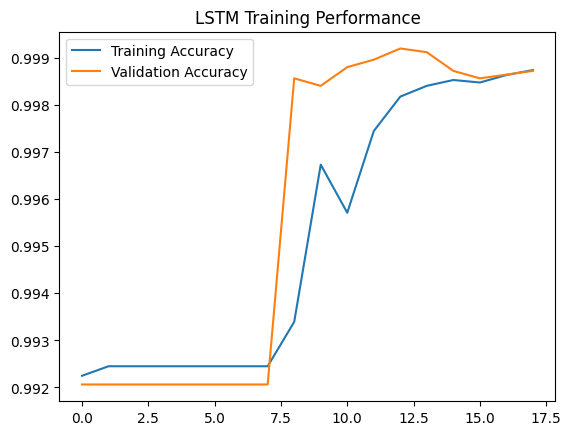

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scale the input data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (3D input)
X_train_lstm = np.expand_dims(X_train_scaled, axis=-1)
X_test_lstm = np.expand_dims(X_test_scaled, axis=-1)

# Build the LSTM model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with a slightly increased learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Add EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

# Plot training performance
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Performance')
plt.legend()
plt.show()


# Model Summary and Evaluation

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Print the model summary
model.summary()

# Make predictions
y_pred_prob = model.predict(X_test_lstm)  # Probabilities from the sigmoid output
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 15, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,901 (89.46 KB)

 Trainable params: 7,633 (29.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,268 (59.64 KB)

394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Model Performance Metrics:
Accuracy: 0.9992
Precision: 0.9999
Recall: 0.9993
F1-Score: 0.9996

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       100
           1       1.00      1.00      1.00     12498

    accuracy                           1.00     12598
   macro avg       0.96      0.99      0.98     12598
weighted avg       1.00      1.00      1.00     12598


Confusion Matrix:
[[   99     1]
 [    9 12489]]


# Predicting uncertainity using Fuzzy Logic

394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
394/394 ━━━━━━━━

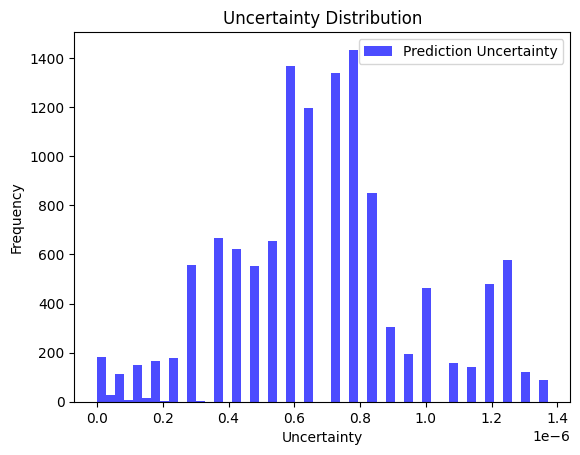

In [24]:
def predict_with_uncertainty(model, X, n_iter=100):
    preds = np.stack([model.predict(X) for _ in range(n_iter)])
    mean_pred = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    return mean_pred, uncertainty

mean_preds, uncertainties = predict_with_uncertainty(model, X_test_lstm)

# Visualize uncertainty
plt.hist(uncertainties, bins=50, alpha=0.7, color='blue', label='Prediction Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.legend()
plt.show()


# Plotting ROC Curve for LSTM model predictions 

##### ROC: Receiver Operating Characteristic

394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


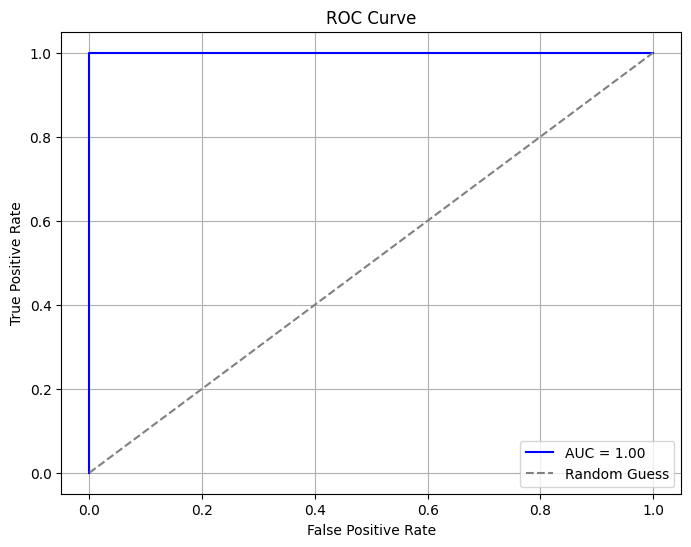

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities from the LSTM model
lstm_probs = model.predict(X_test_lstm).ravel()

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, lstm_probs)

# Generate false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, lstm_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
